In [17]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# [4월 11일]
---

## # 사전 훈련된 컨브넷 사용하기
---
- 작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 매우 효과적인 방법은 사전 훈련된 네트워크를 사용
- 사전 훈련된 네트워크는 일반적으로 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크 
- 원본 데이터셋이 충분히 크고 일반적이라면 사전 훈련된 네트워크에 의해 학습된 특성의 계층 구조는 실제 세상에 대한 일반적인 모델로 효율적인 역할을 할 수 있다. 
- 새로운 문제가 원래 작업과 완전히 다른 클래스에 대한 것이더라도 이런 특성은 많은 컴퓨터 비전 문제에 유용. 예를 들어 (대부분 동물이나 생활 용품으로 이루어진) ImageNet 데이터셋에 네트워크를 훈련한 다음 이 네트워크를 이미지에서 가구 아이템을 식별하는 것 같은 다른 용도로 사용할 수 있다.
- 학습된 특성을 다른 문제에 적용할 수 있는 이런 유연성은 이전의 많은 얕은 학습 방법과 비교했을 때 딥러닝의 핵심 장점. 이런 방식으로 작은 데이터셋을 가진 문제에도 딥러닝이 효율적으로 작동할 수 있다.
- 여기에서는 (1400만 개의 레이블된 이미지와 1,000개의 클래스로 이루어진) ImageNet 데이터셋에서 훈련된 대규모 컨브넷을 사용 
- ImageNet 데이터셋은 다양한 종의 강아지와 고양이를 포함해 많은 동물들을 포함하고 있으며 강아지 vs. 고양이 분류 문제에 좋은 성능을 낼 수 있다.
- 캐런 시몬연과 앤드류 지서먼이 2014년에 개발한 VGG16 구조를 사용 
- VGG16은 간단하고 ImageNet 데이터셋에 널리 사용되는 컨브넷 구조이다. 
- VGG16은 조금 오래되었고 최고 수준의 성능에는 못미치며 최근의 다른 모델보다는 조금 무겁다.
- 하지만 이 모델의 구조가 이전에 보았던 것과 비슷해서 새로운 개념을 도입하지 않고 이해하기 쉽기 때문에 선택. 
- 이런 이름에는 VGG, ResNet, Inception, Inception-ResNet, Xception 등이 있으며 컴퓨터 비전을 위해 딥러닝을 계속 공부하다보면 이런 이름을 자주 만나게 된다.
- 사전 훈련된 네트워크를 사용하는 두 가지 방법이 있는데 특성 추출과 미세 조정이다.
- 합성곱 층만 재사용하는 이유는 합성곱 층에 의해 학습된 표현이 더 일반적이어서 재사용이 가능하기 때문이다. 
- 컨브넷의 특성 맵은 사진에 대한 일반적인 컨셉의 존재 여부를 기록한 맵입니다. 그래서 주어진 컴퓨터 비전 문제에 상관없이 유용하게 사용할 수 있다.
- 하지만 분류기에서 학습한 표현은 모델이 훈련된 클래스 집합에 특화되어 있다. 
- 분류기는 전체 사진에 어떤 클래스가 존재할 확률에 관한 정보만을 담고 있다. 더군다나 완전 연결 층에서 찾은 표현은 더 이상 입력 이미지에 있는 객체의 위치 정보를 가지고 있지 않다. 
- 완전 연결 층들은 공간 개념을 제거하지만 합성곱의 특성 맵은 객체의 위치를 고려한다. 
- 객체의 위치가 중요한 문제라면 완전 연결 층에서 만든 특성은 크게 쓸모가 없다.

- 특정 합성곱 층에서 추출한 표현의 일반성(그리고 재사용성)의 수준은 모델에 있는 층의 깊이에 달려 있다. 
- 모델의 하위 층은 (에지, 색깔, 질감 등과 같이) 지역적이고 매우 일반적인 특성 맵을 추출한다. 
- 반면 상위 층은 ('강아지 눈'이나 '고양이 귀'와 같이) 좀 더 추상적인 개념을 추출한다. 
- 만약 새로운 데이터셋이 원본 모델이 훈련한 데이터셋과 많이 다르다면 전체 합성곱 기반층을 사용하는 것보다는 모델의 하위 층 몇 개만 특성 추출에 사용하는 것이 좋다.
- 합성곱 층만 재사용하는 이유는 합성곱 층에 의해 학습된 표현이 더 일반적이어서 재사용이 가능하기 때문이다. 
- 컨브넷의 특성 맵은 사진에 대한 일반적인 컨셉의 존재 여부를 기록한 맵입니다. 그래서 주어진 컴퓨터 비전 문제에 상관없이 유용하게 사용할 수 있다.
- 하지만 분류기에서 학습한 표현은 모델이 훈련된 클래스 집합에 특화되어 있다. 
- 분류기는 전체 사진에 어떤 클래스가 존재할 확률에 관한 정보만을 담고 있다. 더군다나 완전 연결 층에서 찾은 표현은 더 이상 입력 이미지에 있는 객체의 위치 정보를 가지고 있지 않다. 
- 완전 연결 층들은 공간 개념을 제거하지만 합성곱의 특성 맵은 객체의 위치를 고려한다. 
- 객체의 위치가 중요한 문제라면 완전 연결 층에서 만든 특성은 크게 쓸모가 없다.

- 특정 합성곱 층에서 추출한 표현의 일반성(그리고 재사용성)의 수준은 모델에 있는 층의 깊이에 달려 있다. 
- 모델의 하위 층은 (에지, 색깔, 질감 등과 같이) 지역적이고 매우 일반적인 특성 맵을 추출한다. 
- 반면 상위 층은 ('강아지 눈'이나 '고양이 귀'와 같이) 좀 더 추상적인 개념을 추출한다. 
- 만약 새로운 데이터셋이 원본 모델이 훈련한 데이터셋과 많이 다르다면 전체 합성곱 기반층을 사용하는 것보다는 모델의 하위 층 몇 개만 특성 추출에 사용하는 것이 좋다.


## # 특성 추출
---
* `weights`는 모델을 초기화할 가중치 체크포인트를 지정합니다.
* `include_top`은 네트워크의 최상위 완전 연결 분류기를 포함할지 안할지를 지정합니다. 기본값은 ImageNet의 1,000개의 클래스에 대응되는 완전 연결 분류기를 포함합니다. 별도의 (강아지와 고양이 두 개의 클래스를 구분하는) 완전 연결 층을 추가하려고 하므로 이를 포함시키지 않습니다.
* `input_shape`은 네트워크에 주입할 이미지 텐서의 크기입니다. 이 매개변수는 선택사항입니다. 이 값을 지정하지 않으면 네트워크가 어떤 크기의 입력도 처리할 수 있습니다.



In [2]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', # imagenet으로 학습한 가중치
                 include_top = False,  # 최상위 완전 연결 분류기에 대한 포함 여부
                 input_shape = (150, 150, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### # 데이터 증식을 사용하지 않는 빠른 특성 추출
---
* 새로운 데이터셋에서 합성곱 기반층을 실행하고 출력을 넘파이 배열로 디스크에 저장합니다. 그 다음 이 데이터를 독립된 완전 연결 분류기에 입력으로 사용합니다. 합성곱 연산은 전체 과정 중에서 가장 비싼 부분입니다. 이 방식은 모든 입력 이미지에 대해 합성곱 기반층을 한 번만 실행하면 되기 때문에 빠르고 비용이 적게 듭니다. 하지만 이런 이유 때문에 이 기법에는 데이터 증식을 사용할 수 없습니다.

In [ ]:
# 사전 훈련된 합성곱 기반 층을 사용한 특성 추출

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/drive/MyDrive/workspace/cakd5/m9_딥러닝 알고리즘 구현/data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size = (150, 150),
                                            batch_size = batch_size,
                                            class_mode = 'binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# 완전 연결 분류기에 주입하기 위해 데이터를 평활화

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [ ]:
# 완전 연결 분류기를 정의하고 훈련하기

from tensorflow.keras import models, layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = optimizers.RMSprop(learning_rate = 0.00002), # 2e-5
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(train_features, train_labels,
                    epochs = 30,
                    batch_size = 20,
                    validation_data = (validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 5ms/step - loss: 0.6256 - acc: 0.6565 - val_loss: 0.4632 - val_acc: 0.8240
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - loss: 0.4343 - acc: 0.8000 - val_loss: 0.3722 - val_acc: 0.8670
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3601 - acc: 0.8525 - val_loss: 0.3278 - val_acc: 0.8790
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3143 - acc: 0.8675 - val_loss: 0.3022 - val_acc: 0.8840
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2875 - acc: 0.8855 - val_loss: 0.2847 - val_acc: 0.8900
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2679 - acc: 0.8970 - val_loss: 0.2761 - val_acc: 0.8940
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2536 - acc: 0.9015 - val_loss: 0.2664 - val_acc: 0.8950
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

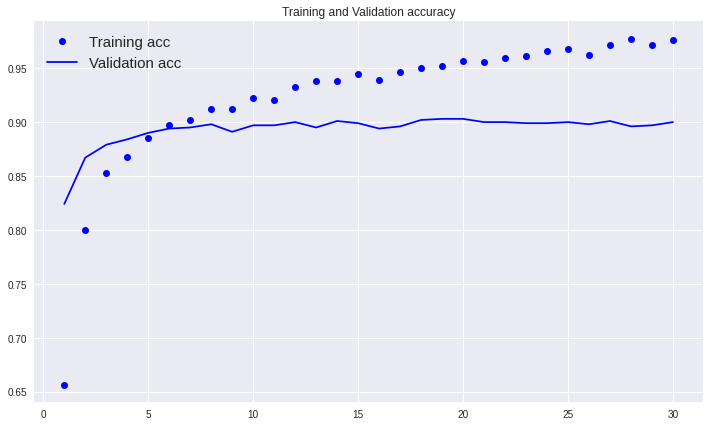

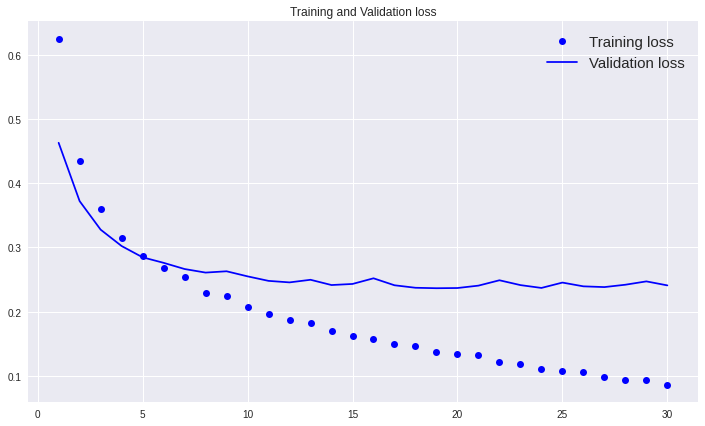

In [ ]:
# 결과 시각화
# 많은 비율로 드롭아웃을 사용했음에도 불구하고 훈련을 시작하면서 거의 바로 과대적합되고 있음
# 작은 이미지 데이터셋에서는 과대적합을 막기 위해 필수적인 데이터 증식을 사용하지 않았기 때문

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (12, 7))
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend(fontsize = 15)

plt.figure(figsize = (12, 7))
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend(fontsize = 15)
plt.show()

### # 데이터 증식을 사용한 특성 추출
---
* 준비한 모델(`conv_base`) 위에 `Dense` 층을 쌓아 확장합니다. 그 다음 입력 데이터에서 엔드 투 엔드로 전체 모델을 실행합니다. 모델에 노출된 모든 입력 이미지가 매번 합성곱 기반층을 통과하기 때문에 데이터 증식을 사용할 수 있습니다. 하지만 이런 이유로 이 방식은 첫 번째 방식보다 훨씬 비용이 많이 듭니다.
- 이 방법은 훨씬 느리고 비용이 많이 들지만 훈련하는 동안 데이터 증식 기법을 사용할 수 있습니다. 
- `conv_base` 모델을 확장하고 입력 데이터를 사용해 엔드 투 엔드로 실행합니다.
- 이 기법은 연산 비용이 크기 때문에 GPU를 사용할 수 있을 때 시도해야 합니다. - CPU에서는 적용하기 매우 힘듭니다. GPU를 사용할 수 없다면 첫 번째 방법을 사용하세요.
- 모델은 층과 동일하게 작동하므로 층을 추가하듯이 `Sequential` 모델에 (`conv_base` 같은) 다른 모델을 추가할 수 있습니다:


In [19]:
# 합성곱 기반 층 위에 완전 연결 분류기 추가

conv_base = VGG16(weights = 'imagenet', # imagenet으로 학습한 가중치
                 include_top = False,  # 최상위 완전 연결 분류기에 대한 포함 여부
                 input_shape = (150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 사전에 학습된 표현을 훼손하지 않기 위해 합성곱 기반 층을 동결

conv_base.trainable = True
print('conv_base를 동결하기 전 훈련되는 가중치의 수 :', len(model.trainable_weights))

conv_base.trainable = False
print('conv_base를 동결한 후 훈련되는 가중치의 수 :', len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수 : 30
conv_base를 동결한 후 훈련되는 가중치의 수 : 4


In [ ]:
# 동결된 합성곱 기반 층과 층과 함께 모델을 엔드-투-엔드로 훈련

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

base_dir = '/content/drive/MyDrive/workspace/cakd5/m9_딥러닝 알고리즘 구현/data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale = 1./255) # 검증 데이터는 절대 증식하면 안된다.

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150, 150), # 이미지 크기를 150 x 150으로 변경
                                                    batch_size = 20,
                                                    class_mode = 'binary') # binary_crossentropy를 사용하므로 이진 레이블이 필요

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size = (150, 150),
                                                        batch_size = 20,
                                                        class_mode = 'binary')

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate = 2e-5),
              metrics = ['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch = 100,
                              epochs = 30,
                              validation_data = validation_generator,
                              validation_steps = 50,
                              verbose = 2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
100/100 - 385s - loss: 0.5580 - acc: 0.7235 - val_loss: 0.4104 - val_acc: 0.8530 - 385s/epoch - 4s/step
Epoch 2/30
100/100 - 22s - loss: 0.4155 - acc: 0.8290 - val_loss: 0.3357 - val_acc: 0.8690 - 22s/epoch - 220ms/step
Epoch 3/30
100/100 - 22s - loss: 0.3571 - acc: 0.8520 - val_loss: 0.3101 - val_acc: 0.8720 - 22s/epoch - 220ms/step
Epoch 4/30
100/100 - 22s - loss: 0.3305 - acc: 0.8625 - val_loss: 0.2879 - val_acc: 0.8850 - 22s/epoch - 219ms/step
Epoch 5/30
100/100 - 22s - loss: 0.3032 - acc: 0.8790 - val_loss: 0.2698 - val_acc: 0.8940 - 22s/epoch - 218ms/step
Epoch 6/30
100/100 - 22s - loss: 0.2890 - acc: 0.8780 - val_loss: 0.2620 - val_acc: 0.8950 - 22s/epoch - 219ms/step
Epoch 7/30
100/100 - 22s - loss: 0.2746 - acc: 0.8925 - val_loss: 0.2611 - val_acc: 0.8950 - 22s/epoch - 220ms/step
Epoch 8/30
100/100 - 22s - loss: 0.2730 - acc: 0.8915 - val_loss: 0.2503 - val_acc: 0.8970 - 22s/epoch - 218ms/step
Epoch 9/30
100/100 - 22s - loss: 0.2595 - acc: 0.8990 - val_loss: 0.2604 

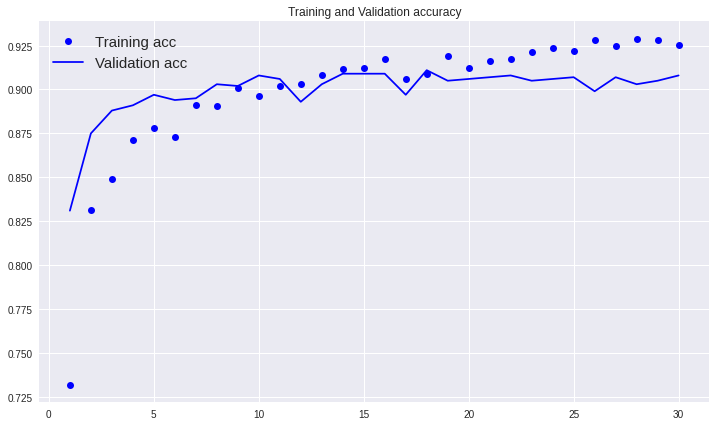

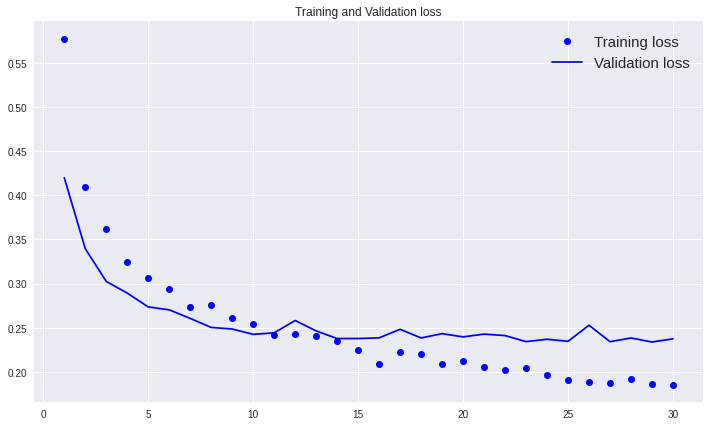

In [ ]:
# 결과 시각화
# 검증 정확도는 데이터 증식을 하지 않은 방법과 비슷하지만 과대적합이 더 줄어들었다.

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (12, 7))
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend(fontsize = 15)

plt.figure(figsize = (12, 7))
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend(fontsize = 15)
plt.show()

# [4월 12일]
---

## # 미세 조정
---
모델을 재사용하는 데 널리 사용되는 또 하나의 기법은 특성 추출을 보완하는 미세 조정입니다. 미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련하는 것입니다. 주어진 문제에 조금 더 밀접하게 재사용 모델의 표현을 일부 조정하기 때문에 미세 조정이라고 부릅니다.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)


In [144]:
# 특정 층까지 모든 층 동결

from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', # imagenet으로 학습한 가중치
                 include_top = False,  # 최상위 완전 연결 분류기에 대한 포함 여부
                 input_shape = (150, 150, 3))

conv_base.trainable = True

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        layer.trainable = True
    elif layer.name == 'block5_conv2':
        layer.trainable = True
    elif layer.name == 'block5_conv3':
        layer.trainable = True
    else:
        layer.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

print(len(model.trainable_weights))

10


In [145]:
# 모델 미세 조정

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

base_dir = '/content/drive/MyDrive/workspace/cakd5/m9_딥러닝 알고리즘 구현/data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale = 1./255) # 검증 데이터는 절대 증식하면 안된다.

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150, 150), # 이미지 크기를 150 x 150으로 변경
                                                    batch_size = 20,
                                                    class_mode = 'binary') # binary_crossentropy를 사용하므로 이진 레이블이 필요

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size = (150, 150),
                                                        batch_size = 20,
                                                        class_mode = 'binary')
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(learning_rate = 1e-5),
              metrics = ['acc'])

history = model.fit(train_generator,
                    epochs = 100,
                    validation_data = validation_generator)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 23s 224ms/step - loss: 0.5615 - acc: 0.7270 - val_loss: 0.3156 - val_acc: 0.8750
Epoch 2/100
100/100 [==============================] - 22s 221ms/step - loss: 0.3003 - acc: 0.8650 - val_loss: 0.2229 - val_acc: 0.8980
Epoch 3/100
100/100 [==============================] - 23s 229ms/step - loss: 0.2257 - acc: 0.9110 - val_loss: 0.1973 - val_acc: 0.9120
Epoch 4/100
100/100 [==============================] - 22s 222ms/step - loss: 0.2018 - acc: 0.9155 - val_loss: 0.1944 - val_acc: 0.9130
Epoch 5/100
100/100 [==============================] - 22s 221ms/step - loss: 0.1684 - acc: 0.9315 - val_loss: 0.1857 - val_acc: 0.9230
Epoch 6/100
100/100 [==============================] - 22s 220ms/step - loss: 0.1560 - acc: 0.9310 - val_loss: 0.1783 - val_acc: 0.9280
Epoch 7/100
100/100 [==============================] - 23s 233ms/step - loss: 0.1341 - acc: 0.9490 -

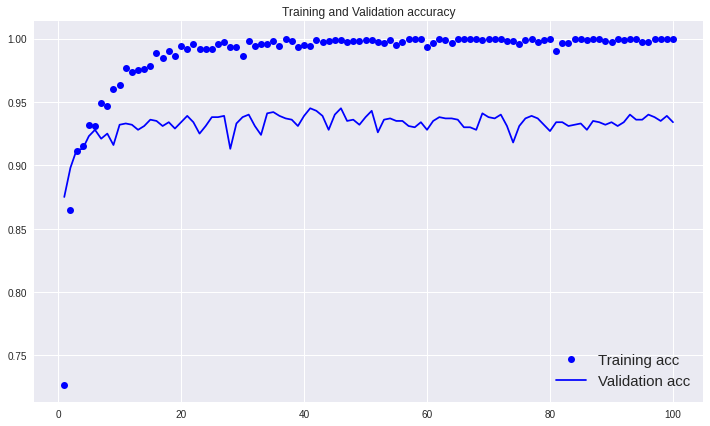

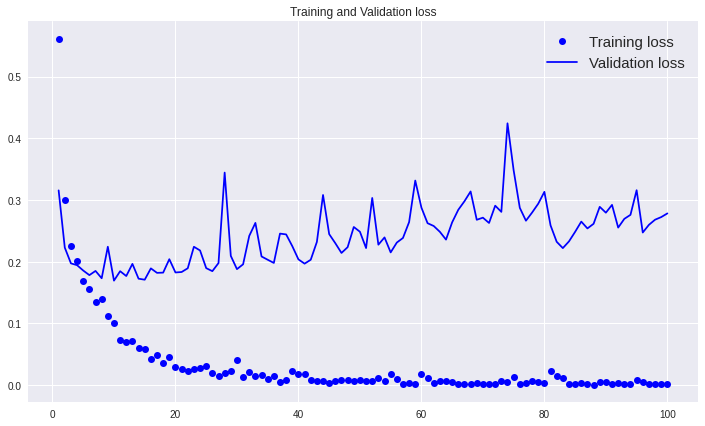

In [146]:
# 미세 조정한 모델 검증 시각화

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (12, 7))
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend(fontsize = 15)

plt.figure(figsize = (12, 7))
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend(fontsize = 15)
plt.show()

In [139]:
# 특정 층까지 모든 층 동결

conv_base.trainable = True

set_trainable = 0
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = 1
    if set_trainable == 1:
        layer.trainable = True
        print(set_trainable)
    elif set_trainable == 0:
        layer.trainable = False
        print(set_trainable)

print('conv_base를 동결한 후 훈련되는 가중치의 수 :', len(model.trainable_weights))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
conv_base를 동결한 후 훈련되는 가중치의 수 : 10
